# Rule-Based Model Design

The **rule-based model** evaluates players across different **macro roles** (GK, DEF, MID, ATT) by combining role-specific performance metrics.  

Football performance is assessed in two complementary dimensions:

- **Per-90 evaluation:** how productive a player is on average when on the pitch, regardless of total minutes played

- **Seasonal evaluation:** how much the player actually contributed across the full season, weighting performance by playing time and team context

### Core Principles

- **Per-90 normalization**: ensures fair comparisons across players with different playing times

- **Season totals**: capture overall impact, durability, and consistency across the year

- **Role-specific indices**: tailor the evaluation to macro roles, highlighting what matters most for each position

- **Negative factors** (yellow/red cards, own goals, goals conceded): penalize costly mistakes

- **Impact factor on team league position**: rewards players who played many minutes for successful teams

- **Finishing delta**: difference between goals and xG, highlighting players who consistently outperform or underperform expected finishing.  

### Metrics for Per-90 Evaluation

**Scoring & Shooting**

- `goals_per90`, `xg_total_per90`, `shots_on_target_per90`: finishing efficiency

- `finishing_delta_per90 = goals_per90 – xg_total_per90`: finishing quality relative to chances

**Passing & Creativity**

- `assists_per90`, `key_passes_per90`: chance creation

- `passes_attempted_per90`, `passes_completed_per90`, `pass_accuracy`: volume and efficiency

- `progressive_passes_per90`, `crosses_per90`, `switches`: progression, verticality, and distribution quality

**Carrying & Dribbling**

- `progressive_carries`, `carries_to_penalty_area_per90`, `carry_distance_total_per90`: ball progression on the run

- `dribbles_completed_per90`, `dribbles_success_rate`: 1v1 ability

**Defensive Actions**

- `duels_won_per90`, `duels_success_rate`, `interceptions_won_per90`, `interceptions_ratio`, `blocks_per90`, `clearances_per90`, `ball_recoveries_per90`, `pressures_per90`: defensive efficiency and anticipation.  

**Goalkeeper Metrics**

- `gk_save_ratio`, `gk_saves_per90`: shot-stopping quality

- `gk_goals_conceded_per90` (negative): penalizes frequent conceding

> **NOTE**: For ratio/percentage metrics (e.g., `pass_accuracy`, `dribbles_success_rate`, ...) no true per-90 version is computed, as they are already normalized

### Metrics for Seasonal Evaluation

**General**

- `minutes_played`: overall availability

- `team_league_position`: context adjustment (bonus for higher-ranked teams)

- Combined into an **impact factor**

**Scoring & Shooting**

- `goals`, `xg_total`, `shots_on_target`: season-long scoring output

- `finishing_delta = goals – xg_total`: over/under-performance relative to xG

**Passing & Creativity**

- `assists`, `key_passes`: total creative output

- `passes_attempted`, `passes_completed`, `pass_accuracy`: build-up contribution

- `progressive_passes`, `crosses`, `switches`: progression and verticality across the season

**Carrying & Dribbling**

- `progressive_carries`, `carries_to_penalty_area`, `carry_distance_total`: total ball progression

- `dribbles_completed`, `dribbles_success_rate`: successful take-ons across the year

**Defensive Actions**

- `duels_won`, `duels_success_rate`, `interceptions_won`, `interceptions_ratio`, `blocks`, `clearances`, `ball_recoveries`, `pressures`: defensive volume and effectiveness over the season  

**Goalkeeper Metrics**

- `gk_saves`, `gk_penalties_saved`, `gk_clean_sheet`: total contributions to preventing goals

- `gk_save_ratio`: efficiency of shot-stopping

- `gk_goals_conceded` (negative): total goals conceded

**Discipline (Negative Impact)**

- `yellow_cards`, `red_cards`, `own_goals`: season-long negative contributions

**Fouls**

- `fouls_won`, `fouls_balance`: ability to win fouls and generate advantageous set-pieces

### Features Not Used

- **Metadata**: `season`, `competitions`, `teams`, `main_role`: identifiers only

- **Redundant playing-time stats**: `presences`, `matches_started`, `full_matches`, `substitutions_in/out`: already captured by `minutes_played` and per-90 scaling

- **Low-discriminative metrics**:  

  - `shots_attempted`: captured better by xG and shots on target

  - `duels_attempted`, `interceptions_attempted`: success rates are more informative

  - `dispossessed`: reflected in dribble success rate.  

### Final Considerations

By combining **per-90 efficiency metrics** with **season totals and contextual impact factors**, the model captures both *quality* and *quantity*:  

- A player with high efficiency but limited minutes will score high in per-90 evaluation but lower in seasonal impact.  
- A consistent starter with thousands of minutes and steady production will shine in seasonal evaluation, even if per-90 efficiency is modest.  

The final Ballon d’Or ranking is presented from two complementary perspectives:  

1. **Best per-90 performers (efficiency)** → how good a player is when on the pitch

2. **Best seasonal contributors (impact)** → who truly shaped the season at scale

## Imports

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

import warnings
warnings.filterwarnings("ignore")

## Dataset Loading

In [2]:
# Load the dataset
df_final = pd.read_csv("../task2_ballon_dor/data/df_final.csv")

# Check shape
print(f"Dataset shape: {df_final.shape[0]} rows, {df_final.shape[1]} columns")

# Preview
display(df_final.head())

# List of columns
print("Available columns:")
for col in df_final.columns:
    print("-", col)


Dataset shape: 2632 rows, 85 columns


,season,player_id,player_name,presences,matches_started,full_matches,minutes_played,substitutions_in,substitutions_out,yellow_cards,...,gk_saves,gk_saves_per90,gk_penalties_saved,gk_save_ratio,gk_clean_sheet,teams,competitions,main_role,team_league_position,macro_role
0,2015/2016,2936,Christophe Kerbrat,29,29,28,2755,0,1,7,...,0,0.00,0,0.000000,0,['Guingamp'],['France - Ligue 1'],Right Center Back,16,DEF
1,2015/2016,2943,Lucas Deaux,16,13,10,1266,3,3,3,...,0,0.00,0,0.000000,0,['Nantes'],['France - Ligue 1'],Right Defensive Midfield,13,MID
2,2015/2016,2944,Benjamin Corgnet,16,5,1,613,11,4,0,...,0,0.00,0,0.000000,0,['Saint-Étienne'],['France - Ligue 1'],Center Attacking Midfield,6,MID
3,2015/2016,2946,Frédéric Guilbert,29,28,26,2574,1,2,3,...,0,0.00,0,0.000000,0,['Bordeaux'],['France - Ligue 1'],Right Center Back,14,DEF
4,2015/2016,2947,Anthony Lopes,37,37,37,3548,0,0,2,...,105,2.66,0,0.492958,13,['Lyon'],['France - Ligue 1'],Goalkeeper,2,GK


Available columns:
- season
- player_id
- player_name
- presences
- matches_started
- full_matches
- minutes_played
- substitutions_in
- substitutions_out
- yellow_cards
- red_cards
- shots_attempted
- shots_attempted_per90
- shots_on_target
- shots_on_target_per90
- goals
- goals_per90
- xg_total
- xg_total_per90
- assists
- assists_per90
- key_passes
- key_passes_per90
- passes_attempted
- passes_attempted_per90
- passes_completed
- passes_completed_per90
- pass_accuracy
- progressive_passes
- progressive_passes_per90
- crosses
- crosses_per90
- switches
- carries_attempted
- carries_attempted_per90
- carry_distance_total
- carry_distance_total_per90
- progressive_carries
- carries_to_penalty_area
- carries_to_penalty_area_per90
- dribbles_attempted
- dribbles_attempted_per90
- dribbles_completed
- dribbles_completed_per90
- dribbles_success_rate
- duels_attempted
- duels_attempted_per90
- duels_won
- duels_won_per90
- duels_lost
- interceptions_attempted
- interceptions_attempted_pe

## Initial Filtering

A filtering criteria are applied to ensure that only players with **substantial contributions** in **competitive teams** are considered:

**Playing time**  

   - Players with fewer than **1800 minutes** (≈ 20 full matches) are excluded.  

   - This prevents misleading per-90 statistics caused by small samples (e.g., a substitute scoring once in 90 minutes would appear as 1 goal/90, which is not representative).


In [3]:
# Filter players with at least 1800 minutes played
df_filtered = df_final[df_final["minutes_played"] >= 1800].copy()

print(f"Initial dataset size: {df_final.shape[0]} players")
print(f"Remaining players after filtering (≥1800 minutes): {df_filtered.shape[0]}")
print(f"Players filtered out: {df_final.shape[0] - df_filtered.shape[0]}")

Initial dataset size: 2632 players
Remaining players after filtering (≥1800 minutes): 1017
Players filtered out: 1615


## Add `finishing_delta_per90` and `finishing_delta` to the dataset

Below, two different features are added: `finishing_delta_per90` and `finishing_delta`.
**Finishing delta** refers to the difference between the actual goals scored and the expected goals (xG) based on the quality of the chances. In particular:

1. **Finishing Delta (Total)** is the difference between the total number of goals scored and the total expected goals (xG) across all games. It reflects the player's overall ability to convert chances into goals.

2. **Finishing Delta per 90 minutes** adjusts the total finishing delta to a per-90-minute basis, providing a normalized measure that accounts for the number of minutes played. It gives insight into a player's finishing ability on average per match.

The difference can indicate whether a player is outperforming or underperforming relative to the expected goals based on their chances.

In [4]:
# Compute finishing delta per90
df_filtered["finishing_delta_per90"] = (
    df_filtered["goals_per90"].fillna(0) - df_filtered["xg_total_per90"].fillna(0)
)

# Compute finishing delta
df_filtered["finishing_delta"] = (
    df_filtered["goals"].fillna(0) - df_filtered["xg_total"].fillna(0)
)




# Players of interest
players = ["Harry Kane", "Luis Suárez", "Gonzalo Higuaín", "Robert Lewandowski", "Zlatan Ibrahimović"]

# Columns to display
cols = [
    "player_name", "goals", "xg_total", 
    "goals_per90", "xg_total_per90", 
    "finishing_delta_per90", "finishing_delta"
]

# Display results
display(df_filtered[df_filtered["player_name"].isin(players)][cols])

,player_name,goals,xg_total,goals_per90,xg_total_per90,finishing_delta_per90,finishing_delta
411,Zlatan Ibrahimović,36,22.70,1.26,0.80,0.46,13.30
651,Luis Suárez,40,27.66,1.09,0.75,0.34,12.34
680,Gonzalo Higuaín,36,25.01,1.05,0.73,0.32,10.99
743,Robert Lewandowski,30,24.52,0.99,0.81,0.18,5.48
1697,Harry Kane,25,21.63,0.63,0.55,0.08,3.37


## Team Impact

The **impact of each player on team success** is quantified through a composite score that balances **individual playing time** with the **league performance** of the player’s team(s).

- **League position (`team_league_position`)**  
  Used as a proxy for **team strength and seasonal success**. Lower values indicate stronger teams (e.g., 1 = champion). The average league position is normalized into a continuous score between 0 and 1:

  $$
  team\_strength = \frac{max(position) - avg\_position}{max(position) - 1} \tag{4}
  $$

- **Minutes played (`minutes_played`)**  
  Represent the effective time a player spent on the pitch. A min–max scaling is applied to normalize values to the [0, 1] interval:

  $$
  norm\_minutes = \frac{minutes\_played - min(minutes)}{max(minutes) - min(minutes)} \tag{4}
  $$

- **Final team impact score**  
  Combines the two components, with an exponent applied to the team strength in order to penalize more strongly players from mid- or low-ranked teams:

  $$
  team\_impact = norm\_minutes \times \big(team\_strength\big)^{penalty\_exp} \tag{4}
  $$

**Notes:**  
- For players with appearances in multiple teams, the **average league position** is considered

- The parameter `penalty_strength` regulates the severity of the penalization:  

  - Values close to 1 → mild penalization of weaker teams

  - Large values (e.g., 10) → only players from top-ranked teams retain significant impact

In [5]:
df = df_filtered.copy()

# Parse team_league_position 
def parse_team_position(x):
    val = ast.literal_eval(str(x))
    if isinstance(val, (list, tuple)):
        return float(np.mean(val))  # average if multiple
    else:
        return float(val)

df["avg_team_position"] = df["team_league_position"].apply(parse_team_position)

# Min and max minutes
min_minutes = df["minutes_played"].min()
max_minutes = df["minutes_played"].max()

# Normalized minutes
df["norm_minutes"] = (df["minutes_played"] - min_minutes) / (max_minutes - min_minutes)

# Normalize team position into team strength (1 = champion, 0 = bottom)
max_position = int(df["avg_team_position"].max())
df["team_strength"] = (max_position - df["avg_team_position"]) / (max_position - 1)

# Apply exponent to team_strength
penalty_strength = 10
df["team_strength"] = df["team_strength"] ** penalty_strength

# Combine normalized minutes and boosted team strength
df["team_impact"] = df["norm_minutes"] * df["team_strength"]

# Players of interest
players = ["Harry Kane", "Luis Suárez", "Gonzalo Higuaín", "Robert Lewandowski", "Zlatan Ibrahimović"]

# Columns to display
cols = [
    "player_name", "minutes_played", 
    "norm_minutes", "avg_team_position", 
    "team_strength", "team_impact"
]

# Display results
display(df[df["player_name"].isin(players)][cols])


,player_name,minutes_played,norm_minutes,avg_team_position,team_strength,team_impact
411,Zlatan Ibrahimović,2568,0.405405,1.0,1.000000,0.405405
651,Luis Suárez,3299,0.792793,1.0,1.000000,0.792793
680,Gonzalo Higuaín,3093,0.683625,2.0,0.582357,0.398113
743,Robert Lewandowski,2736,0.494436,1.0,1.000000,0.494436
1697,Harry Kane,3563,0.932697,3.0,0.328816,0.306686


In [6]:
# Display min and max
min_player = df.loc[df["team_impact"].idxmin(), ["player_name", "macro_role", "minutes_played", "avg_team_position", "team_impact"]]
max_player = df.loc[df["team_impact"].idxmax(), ["player_name", "macro_role", "minutes_played", "avg_team_position", "team_impact"]]

print("Lowest team_impact:")
display(min_player.to_frame().T)

print("\nHighest team_impact:")
display(max_player.to_frame().T)

Lowest team_impact:


,player_name,macro_role,minutes_played,avg_team_position,team_impact
35,Benjamin Nivet,MID,2474,20.0,0.0



Highest team_impact:


,player_name,macro_role,minutes_played,avg_team_position,team_impact
444,Wes Morgan,DEF,3687,1.0,0.99841


In [7]:
df.drop(columns=["team_league_position","norm_minutes", "avg_team_position"], inplace=True)

## Per-90 Evaluation

In [8]:
# Complete metrics list for per-90 evaluation

metrics_per90 = [
    
    # Scoring & Shooting
    "goals_per90", "xg_total_per90", "shots_on_target_per90",
    "finishing_delta_per90",

    # Passing & Creativity
    "assists_per90", "key_passes_per90",
    "passes_attempted_per90", "passes_completed_per90", "pass_accuracy",
    "progressive_passes_per90", "crosses_per90",

    # Carrying & Dribbling
    "progressive_carries", "carries_to_penalty_area_per90", "carry_distance_total_per90",
    "dribbles_completed_per90", "dribbles_success_rate",

    # Defensive Actions
    "duels_won_per90", "duels_success_rate",
    "interceptions_won_per90", "interceptions_ratio",
    "blocks_per90", "clearances_per90", "ball_recoveries_per90", "pressures_per90",

    # Goalkeeper
    "gk_save_ratio", "gk_saves_per90", "gk_goals_conceded_per90",

    # Contextual impact
    "team_impact", "team_strength"
]

In [9]:
# Create a copy of the DataFrame to avoid changing the original data
df_per90 = df[metrics_per90 + ["player_name", "macro_role", "teams"]].copy()

### Weights Definition: Clustering by Role and Determining the Optimal Number of Clusters

A **K-Means clustering** framework is applied to segment players into groups that capture **distinct performance profiles** within each role. The analysis is performed separately for each macro-role to ensure that feature importance is assessed relative to the specific responsibilities and performance expectations of that role.

This clustering-based weighting procedure provides an **objective and unsupervised approach** to feature selection, highlighting the metrics that most effectively separate players according to their role-specific performance patterns. The method avoids arbitrary assumptions about feature relevance and ensures that the analysis remains robust, interpretable, and generalizable.

The procedure consists of two main steps:

1. **Determination of the optimal number of clusters (`k`)**  

   - The **Elbow Method** is employed to select the most appropriate value of `k`

   - For each role, the **inertia** (defined as the sum of squared distances between each data point and its cluster centroid) is computed across a range of cluster values (from 1 to 20)

   - As expected, inertia decreases monotonically with increasing `k`. However, beyond a certain point, the incremental improvement becomes marginal. The **elbow point** — where the curve starts to flatten — indicates the optimal trade-off between cluster compactness and model simplicity

2. **Role-specific clustering**  

   - Once the optimal `k` is identified, **K-Means clustering** is applied to the normalized feature space of each role

   - Data normalization ensures that all metrics contribute equally to the clustering process, avoiding dominance by features with larger absolute values

   - For each role, the algorithm returns the **cluster assignments**, the **centroid positions**, and the **normalized data** for further analysis.  

By analyzing the centroids of the resulting clusters, it becomes possible to evaluate the **relative contribution of each feature** to player differentiation within a role. Features that vary strongly across clusters are deemed more informative, and their importance can subsequently be translated into **data-driven weights** for performance evaluation.


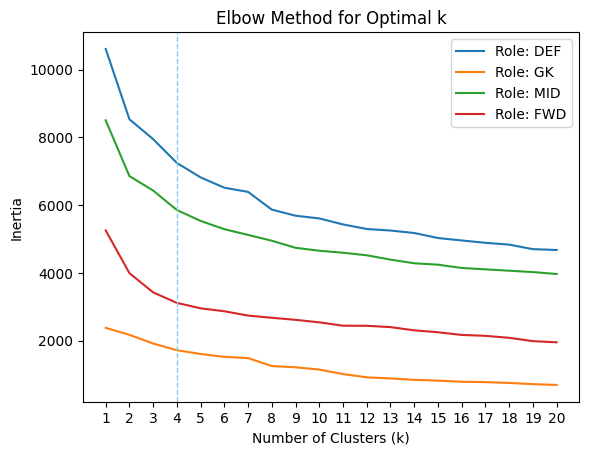

In [10]:
# Function to identify the optimal number of clusters using the Elbow Method
def plot_elbow_method(df, metrics):

    # List of unique roles in the dataset
    roles = df['macro_role'].unique()

    # Loop through each role to find the optimal number of clusters
    for role in roles:

        # Filter data for each role
        role_data = df[df['macro_role'] == role][metrics]

        # Normalize the data
        scaler = StandardScaler()
        role_data_scaled = scaler.fit_transform(role_data)

        # Inertia for different values of k
        inertia = []
        for k in range(1, 21):  # Test values from 1 to 20 for k
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(role_data_scaled)
            inertia.append(kmeans.inertia_)

        # Plot inertia to find the elbow point
        plt.plot(range(1, 21), inertia, label=f'Role: {role}')

    # Plot to find the elbow point
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(range(1, 21))
    plt.legend()
    plt.axvline(x=4, linestyle='--', label='Optimal k', color='skyblue', linewidth=1)
    plt.show()

# Call the function to plot inertia for different roles
plot_elbow_method(df_per90, metrics_per90)


In [11]:
# Function to perform clustering by role using the optimal k
def cluster_by_role(df, metrics, k=4):
    
    # Dictionary to store clustering results by role
    clustering_results = {}

    # List of unique roles in the dataset
    roles = df['macro_role'].unique()
    
    for role in roles:
        # Filter data for each role
        role_data = df[df['macro_role'] == role][metrics]

        # Normalize the data
        scaler = StandardScaler()
        role_data_scaled = scaler.fit_transform(role_data)

        # Perform K-Means clustering with the optimal number of clusters (based on elbow method)
        kmeans = KMeans(n_clusters=k, random_state=42)
        df.loc[df['macro_role'] == role, 'cluster'] = kmeans.fit_predict(role_data_scaled)

        # Store the clustering results for each role
        clustering_results[role] = {
            'centroids': kmeans.cluster_centers_,                       # Store the centroids of the clusters
            'labels': df[df['macro_role'] == role]['cluster'].values,   # Store the cluster labels for each player
            'data': role_data_scaled                                    # Keep track of the role-specific data (normalized)
        }

    return df, clustering_results

# Implement clustering with the optimal k
df_with_clusters, role_weights = cluster_by_role(df_per90, metrics_per90, k=4)

### Extracting Important Features (weights)


Once players have been segmented into clusters within each role, it is necessary to understand **which metrics are actually driving the separation** between groups, in order to retrieve the weights to assign to each feature. To address this, an **Analysis of Variance (ANOVA)** is applied.

By applying ANOVA, it becomes possible to test how much each feature **varies across clusters** compared to how much it varies within them. In fact, if a feature shows **large differences across clusters**, it means that it plays a **key role in distinguishing performance profiles**. If a feature is **constant or very similar across all clusters**, it is less relevant for differentiating players in that role.  

The outcome of the ANOVA test is the **F-statistic**, defined as:

$
F = \frac{\text{variance between clusters}}{\text{variance within clusters}}
$

- **High F values** means that the feature strongly separates clusters (high between-cluster variance relative to within-cluster variance)

- **Low F values** meansthe feature does not meaningfully separate players across clusters.  

This makes the F-statistic a **natural and interpretable measure of feature importance** in the clustering context.

In practice, some features may produce `inf` or `nan` values for the F-statistic:

- `inf` (infinite) occurs when at least one cluster has **zero variance** for that feature (all players have identical values). In this case, the denominator of the F ratio becomes zero.  

- `nan` arises when the feature is **constant across all clusters**, or when missing values prevent a valid calculation.  

To ensure stability and interpretability, such cases are assigned an importance score of zero.  

 
This approache provides a **statistical and objective method** to assess feature importance. In addition, it avoids subjective weighting: the data themselves indicate which metrics are most discriminative.  
Working **role by role** ensure that the importance of features reflects the reality of what differentiates, for example, forwards from one another, or goalkeepers from one another.  

The outcome is a **ranking of features for each role**, which forms the basis for assigning **data-driven weights** in the overall evaluation of players

In [12]:
# Compute feature importance for each role using ANOVA across clusters
def get_important_features(role_weights, metrics):
    important_features = {}

    for role, result in role_weights.items():
        data = result['data']      # normalized data for the role
        labels = result['labels']  # cluster labels for players

        feature_importance = {}

        for i, metric in enumerate(metrics):
            # Group values of the current metric by cluster
            cluster_values = [data[labels == c, i] for c in np.unique(labels)]

            if len(cluster_values) > 1:

                f_stat, p_val = f_oneway(*cluster_values)

                # Sometimes ANOVA returns inf or nan:
                # - inf happens when one cluster has zero variance (all values identical),
                #   which makes the F-statistic undefined → we set it to 0.
                # - nan happens when the feature is constant across all clusters
                #   or contains missing values → we also set it to 0.
                if not np.isfinite(f_stat):
                    f_stat = 0.0

                feature_importance[metric] = f_stat
            else:
                # If there is only one cluster, ANOVA cannot be performed
                feature_importance[metric] = 0.0

        # Store as a sorted Series for easier inspection
        important_features[role] = pd.Series(feature_importance).sort_values(ascending=False)

    return important_features


# Compute feature importance for each role using ANOVA across clusters
important_metrics = get_important_features(role_weights, metrics_per90)

# Display results
for role, importance in important_metrics.items():
    print(f"Top 10 important features for role {role}:")
    print(importance.head(10))
    print("\n")


Top 10 important features for role DEF:
crosses_per90                    386.067679
carries_to_penalty_area_per90    257.121421
clearances_per90                 237.703499
key_passes_per90                 189.946701
dribbles_completed_per90         163.066834
carry_distance_total_per90       144.629575
passes_attempted_per90           120.181400
passes_completed_per90            96.006209
assists_per90                     90.502199
pressures_per90                   84.644240
dtype: float64


Top 10 important features for role GK:
passes_completed_per90        29.067540
passes_attempted_per90        29.060916
progressive_passes_per90      28.597399
pass_accuracy                 27.919456
carry_distance_total_per90    23.941275
team_strength                 20.141335
ball_recoveries_per90         18.750895
team_impact                   17.758681
gk_goals_conceded_per90       15.023806
gk_saves_per90                12.549716
dtype: float64


Top 10 important features for role MID:
carries

### Normalization of Feature Weights for Each Role

In this step, the feature weights for each role are **normalized**. This process standardizes the feature weights, enabling **objective comparison** of feature importance across roles.

For each role, the **sum of the absolute weights** for each feature is calculated. Each feature weight is then divided by the total weight for that role, ensuring that the total weight for each role is normalized to 1.

In addition to normalization, certain metrics are treated as **penalizing factors**, since higher values are detrimental to performance evaluation (e.g., disciplinary records or own goals).


In [13]:
# Function to normalize the weights for each role
def normalize_role_weights(role_weights):
    # Create a dictionary to store the normalized weights
    normalized_weights = {}

    # Iterate over each role and its weights
    for role, weights in role_weights.items():
        
        # Calculate the absolute sum of weights for each role
        total_weight = np.sum(np.abs(weights))

        # Normalize the weights for the role
        normalized_weights[role] = {metric: w / total_weight for metric, w in weights.items()}

    return normalized_weights

# Normalize the weights for each role
normalized_role_weights = normalize_role_weights(important_metrics)

# Display the most and least important normalized features for each role
for role, weights in normalized_role_weights.items():
    most_important = max(weights, key=weights.get)
    least_important = min(weights, key=weights.get)
    print(f"Role: {role}")
    print(f"Most important feature: {most_important} with normalized importance {round(weights[most_important], 2)}")
    print(f"Least important feature: {least_important} with normalized importance {round(weights[least_important], 2)}")
    print("\n")


Role: DEF
Most important feature: crosses_per90 with normalized importance 0.17
Least important feature: gk_save_ratio with normalized importance 0.0


Role: GK
Most important feature: passes_completed_per90 with normalized importance 0.12
Least important feature: interceptions_won_per90 with normalized importance 0.0


Role: MID
Most important feature: carries_to_penalty_area_per90 with normalized importance 0.12
Least important feature: gk_save_ratio with normalized importance 0.0


Role: FWD
Most important feature: xg_total_per90 with normalized importance 0.09
Least important feature: gk_save_ratio with normalized importance 0.0




### Normalization of Metrics

**Min-Max normalization** is applied to scale the selected metrics (stored in `metrics_per90`) between 0 and 1, ensuring that all metrics are on the same scale when calculating the final scores (`per90_points`). This normalization makes it easier to compare results across players and roles by bringing all values into a fixed range.

The goal is to standardize the final scores, preventing any metric from dominating due to its scale, ensuring that all metrics contribute equally.

> **NOTE**: On the other hand, **StandardScaler** was used before clustering to center the data around 0 and scale it to have unit variance. This ensures that the K-Means clustering algorithm treats all features equally, preventing features with larger ranges from dominating the clustering process.

In [14]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the values between 0 and 1
df_per90[metrics_per90] = scaler.fit_transform(df_per90[metrics_per90])

# Print min and max values for each metric with better formatting
print("Min and Max values after normalization:")

# Iterate through each metric and print its min and max values
for metric in metrics_per90:
    print(f"{metric}:")
    print(f"  - Min: {df_per90[metric].min():.2f}")
    print(f"  - Max: {df_per90[metric].max():.2f}")
    print()  

Min and Max values after normalization:
goals_per90:
  - Min: 0.00
  - Max: 1.00

xg_total_per90:
  - Min: 0.00
  - Max: 1.00

shots_on_target_per90:
  - Min: 0.00
  - Max: 1.00

finishing_delta_per90:
  - Min: 0.00
  - Max: 1.00

assists_per90:
  - Min: 0.00
  - Max: 1.00

key_passes_per90:
  - Min: 0.00
  - Max: 1.00

passes_attempted_per90:
  - Min: 0.00
  - Max: 1.00

passes_completed_per90:
  - Min: 0.00
  - Max: 1.00

pass_accuracy:
  - Min: 0.00
  - Max: 1.00

progressive_passes_per90:
  - Min: 0.00
  - Max: 1.00

crosses_per90:
  - Min: 0.00
  - Max: 1.00

progressive_carries:
  - Min: 0.00
  - Max: 1.00

carries_to_penalty_area_per90:
  - Min: 0.00
  - Max: 1.00

carry_distance_total_per90:
  - Min: 0.00
  - Max: 1.00

dribbles_completed_per90:
  - Min: 0.00
  - Max: 1.00

dribbles_success_rate:
  - Min: 0.00
  - Max: 1.00

duels_won_per90:
  - Min: 0.00
  - Max: 1.00

duels_success_rate:
  - Min: 0.00
  - Max: 1.00

interceptions_won_per90:
  - Min: 0.00
  - Max: 1.00

interc

### Evaluation

To evaluate individual performance, a **per90 score** is computed for each player. This score is based on the **most relevant metrics** identified for their role, weighted by the corresponding **normalized importance values** obtained through the clustering and ANOVA procedure.

- For each player, the metrics are multiplied by the role-specific normalized weights

- The weighted contributions are aggregated into a **composite score**, scaled by a factor (×1000) for interpretability

- An optional adjustment applies **global role weights** to reflect the historical bias of the Ballon d’Or toward attacking players

The resulting value, referred to as **`per90_points`**, provides a standardized measure of player performance on a per-90 basis:

$
per90\_points = \Bigg( \sum_{m \in M_{role}} w_{m,role} \cdot feature_m \Bigg) \times role\_weight
$

where:  
- $M_{role}$ = set of relevant metrics for the role  
- $w_{m,role}$ = normalized weight of metric \(m\) for that role  
- $feature_m$ = player’s value for metric \(m\) (per-90 scaled)  
- $role\_weight$ = global adjustment factor by role (optional)  

The **per90 score** provides a data-driven and role-aware evaluation of player performance, based on metrics normalized on a per-90-minute scale. It reflects the extent to which each player excels in the aspects most relevant to their specific role, while enabling fairer comparisons across positions through the use of statistically derived feature weights.

In [15]:
# Define global role weights (tuneable, reflect Ballon d'Or bias towards forwards)
role_global_weights = {
    "GK": 0.9,
    "DEF": 0.925,
    "MID": 0.95,
    "FWD": 1.0
}

# Function to compute the role-specific score using the most relevant metrics and normalized weights
def compute_points(row, adjusted_metrics, normalized_role_weights,
                   role_global_weights, apply_role_weighting=True):
    role = row["macro_role"]
    score = 0  

    important_features = adjusted_metrics[role]
        
    # Sum the weighted scores for the relevant metrics
    for metric, _ in important_features.items():
        # Apply the normalized weight for the metric and add to the score
        weight = normalized_role_weights[role].get(metric, 0.0)
        score += weight * row[metric] * 1000

    # Optionally apply global role weighting
    if apply_role_weighting:
        score *= role_global_weights.get(role, 1.0)

    return score 

# Flag to decide whether to apply role weighting
apply_role_weighting = True

# Calculate the per90_points using the normalized weights for each player
df_per90["per90_points"] = df_per90.apply(
    lambda r: np.ceil(compute_points(
        r, 
        important_metrics, 
        normalized_role_weights,
        role_global_weights,
        apply_role_weighting
    )
    ),
    axis=1
)

# Display the Top 30 players based on per90_points
top30_per90 = df_per90.sort_values("per90_points", ascending=False).head(30)
print("Top 30 players by per-90 points:")
display(top30_per90[["player_name", "macro_role", "per90_points"]])


Top 30 players by per-90 points:


,player_name,macro_role,per90_points
512,Neymar,FWD,548.0
681,Lionel Messi,FWD,535.0
33,Ángel Di María,FWD,487.0
411,Zlatan Ibrahimović,FWD,473.0
771,Paulo Dybala,FWD,450.0
237,Alexis Sánchez,FWD,442.0
651,Luis Suárez,FWD,417.0
433,Lucas Moura,FWD,416.0
379,Sofiane Boufal,FWD,415.0
171,Henrikh Mkhitaryan,FWD,408.0


## Seasonal Evaluation

The same logic applied to the **per90 score** is extended to compute the **seasonal points**, which represent an aggregate evaluation of a player’s performance over the entire season.  

While the **per90 score** normalizes performance metrics on a per-90-minute basis (facilitating comparisons independent of playing time), the **seasonal points** incorporate **cumulative season totals**, capturing the player’s overall contribution across all appearances.  

In this formulation:  

- The same **role-specific feature weights** (derived from clustering and ANOVA) are used to ensure consistency in the evaluation framework.  

- Instead of per-90 normalized values, the **absolute season metrics** are employed  

- The resulting score therefore reflects both **performance quality** and **sustained involvement** over the season.  

In [16]:
# Complete metrics list for season evaluation
metrics = [
    
    # Scoring & Shooting
    "goals", "xg_total", "shots_on_target",
    "finishing_delta",

    # Passing & Creativity
    "assists", "key_passes",
    "passes_attempted", "passes_completed", "pass_accuracy",
    "progressive_passes", "crosses", "switches",

    # Carrying & Dribbling
    "progressive_carries", "carries_to_penalty_area", "carry_distance_total",
    "dribbles_completed", "dribbles_success_rate",

    # Defensive Actions
    "duels_won", "duels_success_rate",
    "interceptions_won", "interceptions_ratio",
    "blocks", "clearances", "ball_recoveries", "pressures",

    # Goalkeeper
    "gk_save_ratio", "gk_saves", "gk_goals_conceded", 
    "gk_penalties_saved", "gk_clean_sheet",

    # Discipline
    "yellow_cards", "red_cards", "own_goals",

    # Fouls
    "fouls_won", "fouls_balance",

    # Contextual impact
    "team_impact", "team_strength"
]

In [17]:
# Create a copy of the DataFrame to avoid changing the original data
df_seasonal = df.copy()

### Weights Definition: Clustering by Role and Determining the Optimal Number of Clusters

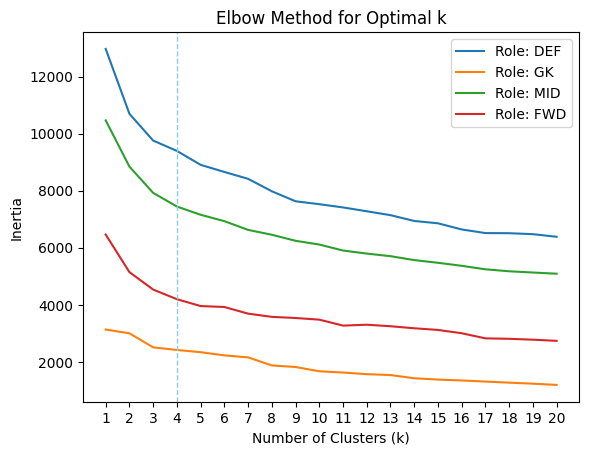

In [18]:
# Call the function to plot inertia for different roles
plot_elbow_method(df_seasonal, metrics)

In [19]:
# Implement clustering with the optimal k (replace 4 with the actual value based on the elbow method)
df_with_clusters, role_weights = cluster_by_role(df_seasonal, metrics, k=4)

### Extracting Important Features


In [20]:
# Extract the most important metrics
important_metrics = get_important_features(role_weights, metrics)

# Display the most important metrics for each role
for role, importance in important_metrics.items():
    print(f"Important features for role {role}:")
    print(importance.head(10))  # Display the top important metrics for each role
    print("\n")

Important features for role DEF:
crosses                    222.859788
carry_distance_total       166.656023
passes_attempted           157.081199
carries_to_penalty_area    146.342558
passes_completed           139.266395
dribbles_completed         138.925272
key_passes                 129.895800
progressive_carries        100.737508
ball_recoveries             86.552020
pressures                   82.378265
dtype: float64


Important features for role GK:
passes_attempted        55.796393
progressive_passes      42.994077
carry_distance_total    42.401805
team_impact             41.814410
team_strength           40.555819
gk_saves                29.772533
ball_recoveries         28.874625
passes_completed        27.517123
gk_clean_sheet          25.876812
progressive_carries     20.579902
dtype: float64


Important features for role MID:
carries_to_penalty_area    118.744226
passes_attempted           112.994424
carry_distance_total       107.605575
key_passes                  96.019

### Normalization of Feature Weights for Each Role and Discipline Penalization

In [21]:
# Normalize the weights for each role
normalized_role_weights = normalize_role_weights(important_metrics)

# Display the most and least important normalized features for each role
for role, weights in normalized_role_weights.items():
    most_important = max(weights, key=weights.get)
    least_important = min(weights, key=weights.get)
    print(f"Role: {role}")
    print(f"Most important feature: {most_important} with normalized importance {round(weights[most_important], 2)}")
    print(f"Least important feature: {least_important} with normalized importance {round(weights[least_important], 2)}")
    print("\n")

Role: DEF
Most important feature: crosses with normalized importance 0.11
Least important feature: gk_penalties_saved with normalized importance 0.0


Role: GK
Most important feature: passes_attempted with normalized importance 0.13
Least important feature: interceptions_ratio with normalized importance 0.0


Role: MID
Most important feature: carries_to_penalty_area with normalized importance 0.07
Least important feature: gk_penalties_saved with normalized importance 0.0


Role: FWD
Most important feature: carry_distance_total with normalized importance 0.1
Least important feature: gk_saves with normalized importance 0.0




In [22]:
# Define penalizing weights (negative multipliers)
negative_weights = [
    "yellow_cards",
    "red_cards",
    "own_goals"
]

# Apply negative weights to the normalized_role_weights
for role, metr in normalized_role_weights.items():
    for metric in metr.keys():
        if metric in negative_weights:
            # Flip the sign of the weight
            metr[metric] = -abs(metr[metric])


### Normalization of Metrics

In [23]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the values between 0 and 1
df_seasonal[metrics] = scaler.fit_transform(df_seasonal[metrics])

# Print min and max values for each metric with better formatting
print("Min and Max values after normalization:")

# Iterate through each metric and print its min and max values
for metric in metrics:
    print(f"{metric}:")
    print(f"  - Min: {df_seasonal[metric].min():.2f}")
    print(f"  - Max: {df_seasonal[metric].max():.2f}")
    print()

Min and Max values after normalization:
goals:
  - Min: 0.00
  - Max: 1.00

xg_total:
  - Min: 0.00
  - Max: 1.00

shots_on_target:
  - Min: 0.00
  - Max: 1.00

finishing_delta:
  - Min: 0.00
  - Max: 1.00

assists:
  - Min: 0.00
  - Max: 1.00

key_passes:
  - Min: 0.00
  - Max: 1.00

passes_attempted:
  - Min: 0.00
  - Max: 1.00

passes_completed:
  - Min: 0.00
  - Max: 1.00

pass_accuracy:
  - Min: 0.00
  - Max: 1.00

progressive_passes:
  - Min: 0.00
  - Max: 1.00

crosses:
  - Min: 0.00
  - Max: 1.00

switches:
  - Min: 0.00
  - Max: 1.00

progressive_carries:
  - Min: 0.00
  - Max: 1.00

carries_to_penalty_area:
  - Min: 0.00
  - Max: 1.00

carry_distance_total:
  - Min: 0.00
  - Max: 1.00

dribbles_completed:
  - Min: 0.00
  - Max: 1.00

dribbles_success_rate:
  - Min: 0.00
  - Max: 1.00

duels_won:
  - Min: 0.00
  - Max: 1.00

duels_success_rate:
  - Min: 0.00
  - Max: 1.00

interceptions_won:
  - Min: 0.00
  - Max: 1.00

interceptions_ratio:
  - Min: 0.00
  - Max: 1.00

blocks:

### Evaluation

In [24]:
# Flag to enable or disable role weighting (same measures as per-90)
apply_role_weighting = True

# Calculate the seasonal_points using the normalized weights for each player
df_seasonal["seasonal_points"] = df_seasonal.apply(
    lambda r: np.ceil(
        compute_points(
            r,
            important_metrics,
            normalized_role_weights,
            role_global_weights,
            apply_role_weighting
        )
    ),
    axis=1
)

# Display the Top 30 players based on seasonal_points
top30_seasonal = (
    df_seasonal.sort_values("seasonal_points", ascending=False)
    .head(30)
)

print("Top 30 players by seasonal points:")
display(top30_seasonal[["player_name", "macro_role", "seasonal_points"]])

Top 30 players by seasonal points:


,player_name,macro_role,seasonal_points
512,Neymar,FWD,575.0
681,Lionel Messi,FWD,518.0
446,Kasper Schmeichel,GK,458.0
1084,Marek Hamšík,MID,440.0
914,Franco Vázquez,MID,436.0
303,Mesut Özil,MID,433.0
57,Christian Eriksen,FWD,431.0
1676,Jonathan Viera,FWD,426.0
878,Ryad Boudebouz,MID,415.0
445,Riyad Mahrez,MID,410.0


## Final Ranking Balon d'or 2015/16

The final ranking combines the two complementary perspectives of player performance.  
On one side, the **per90 score** highlights efficiency and quality on a per-match basis, showing how impactful a player is whenever they are on the pitch.  On the other, the **seasonal points** reflect the cumulative influence of a player across the entire campaign, rewarding sustained contribution over time.  

By merging these two dimensions into a single score, the ranking balances **individual efficiency** with **season-long consistency**. The resulting list identifies the players who not only deliver strong performances in isolated matches but also maintain a decisive role throughout the whole season, offering an objective measure of excellence in line with the spirit of the Ballon d’Or.


In [25]:
# Merge the dataframes on player_name
ranking = pd.merge(
    df_seasonal[["player_name", "teams", "macro_role", "seasonal_points"]], 
    df_per90[["player_name", "per90_points"]], 
    on="player_name", how="inner"
)

# Define the weights for per-90 points and seasonal points
alpha = 0.75
beta = 0.25

# Combine the per-90 points and seasonal points into a final score
ranking["final_points"] = alpha * ranking["per90_points"] + beta * ranking["seasonal_points"]

# Round final points
ranking["final_points"] = ranking["final_points"].round(2)

# Rank players based on final points
top30_final = (
    ranking.sort_values("final_points", ascending=False)
    .head(30)
    .reset_index(drop=True)
)

# Set index starting from 1
top30_final.index = top30_final.index + 1

# Display the top 30 players with their final points
print("Top 30 players by final points:")
display(top30_final[["player_name", "macro_role", "teams", "final_points", "seasonal_points", "per90_points"]])


Top 30 players by final points:


,player_name,macro_role,teams,final_points,seasonal_points,per90_points
1,Neymar,FWD,['Barcelona'],554.75,575.0,548.0
2,Lionel Messi,FWD,['Barcelona'],530.75,518.0,535.0
3,Ángel Di María,FWD,['Paris Saint-Germain'],464.50,397.0,487.0
4,Zlatan Ibrahimović,FWD,['Paris Saint-Germain'],445.75,364.0,473.0
5,Paulo Dybala,FWD,['Juventus'],434.00,386.0,450.0
6,Alexis Sánchez,FWD,['Arsenal'],429.50,392.0,442.0
7,Luis Suárez,FWD,['Barcelona'],407.25,378.0,417.0
8,Mesut Özil,MID,['Arsenal'],403.75,433.0,394.0
9,Sofiane Boufal,FWD,['Lille'],403.50,369.0,415.0
10,Riyad Mahrez,MID,['Leicester City'],400.25,410.0,397.0


## Winner's Stats

In [26]:
# Select winner
player_name = top30_final.loc[1]["player_name"]
winner_info = df[df["player_name"] == player_name]

# Take the first row as dict
info_dict = winner_info.iloc[0].to_dict()

# Choose key columns to display
cols = [
    "player_name", "teams", "competitions", "macro_role", "presences",
    "minutes_played"
] + metrics

# Filter to available columns
cols = [c for c in cols if c in info_dict]

# Print in vertical Markdown
print(f"Player Overview: {player_name}\n")
for col in cols:
    print(f"{col.replace('_', ' ').title()}: {info_dict[col]}")


Player Overview: Neymar

Player Name: Neymar
Teams: ['Barcelona']
Competitions: ['Spain - La Liga']
Macro Role: FWD
Presences: 34
Minutes Played: 3188
Goals: 24
Xg Total: 20.47
Shots On Target: 56
Finishing Delta: 3.530000000000001
Assists: 12
Key Passes: 82
Passes Attempted: 1970
Passes Completed: 1532
Pass Accuracy: 0.7776649746192893
Progressive Passes: 174
Crosses: 71
Switches: 64
Progressive Carries: 322
Carries To Penalty Area: 299
Carry Distance Total: 17188.89
Dribbles Completed: 169
Dribbles Success Rate: 0.6190476190476191
Duels Won: 3
Duels Success Rate: 0.0555555555555555
Interceptions Won: 6
Interceptions Ratio: 0.4615384615384615
Blocks: 29
Clearances: 3
Ball Recoveries: 134
Pressures: 392
Gk Save Ratio: 0.0
Gk Saves: 0
Gk Goals Conceded: 0
Gk Penalties Saved: 0
Gk Clean Sheet: 0
Yellow Cards: 6
Red Cards: 0
Own Goals: 0
Fouls Won: 159
Fouls Balance: 104
Team Impact: 0.7339692633810281
Team Strength: 1.0
